In [204]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [205]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

In [206]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 28, 28)

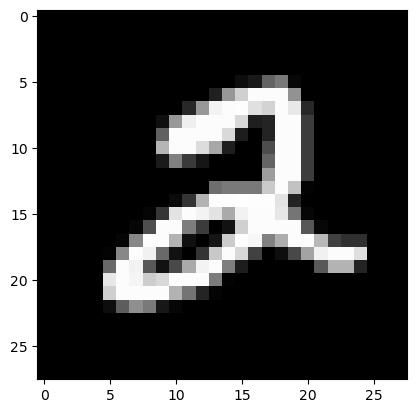

In [207]:
plt.imshow(x_train[5], cmap='gray')

# Reshape the data to fit the model

In [208]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [209]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

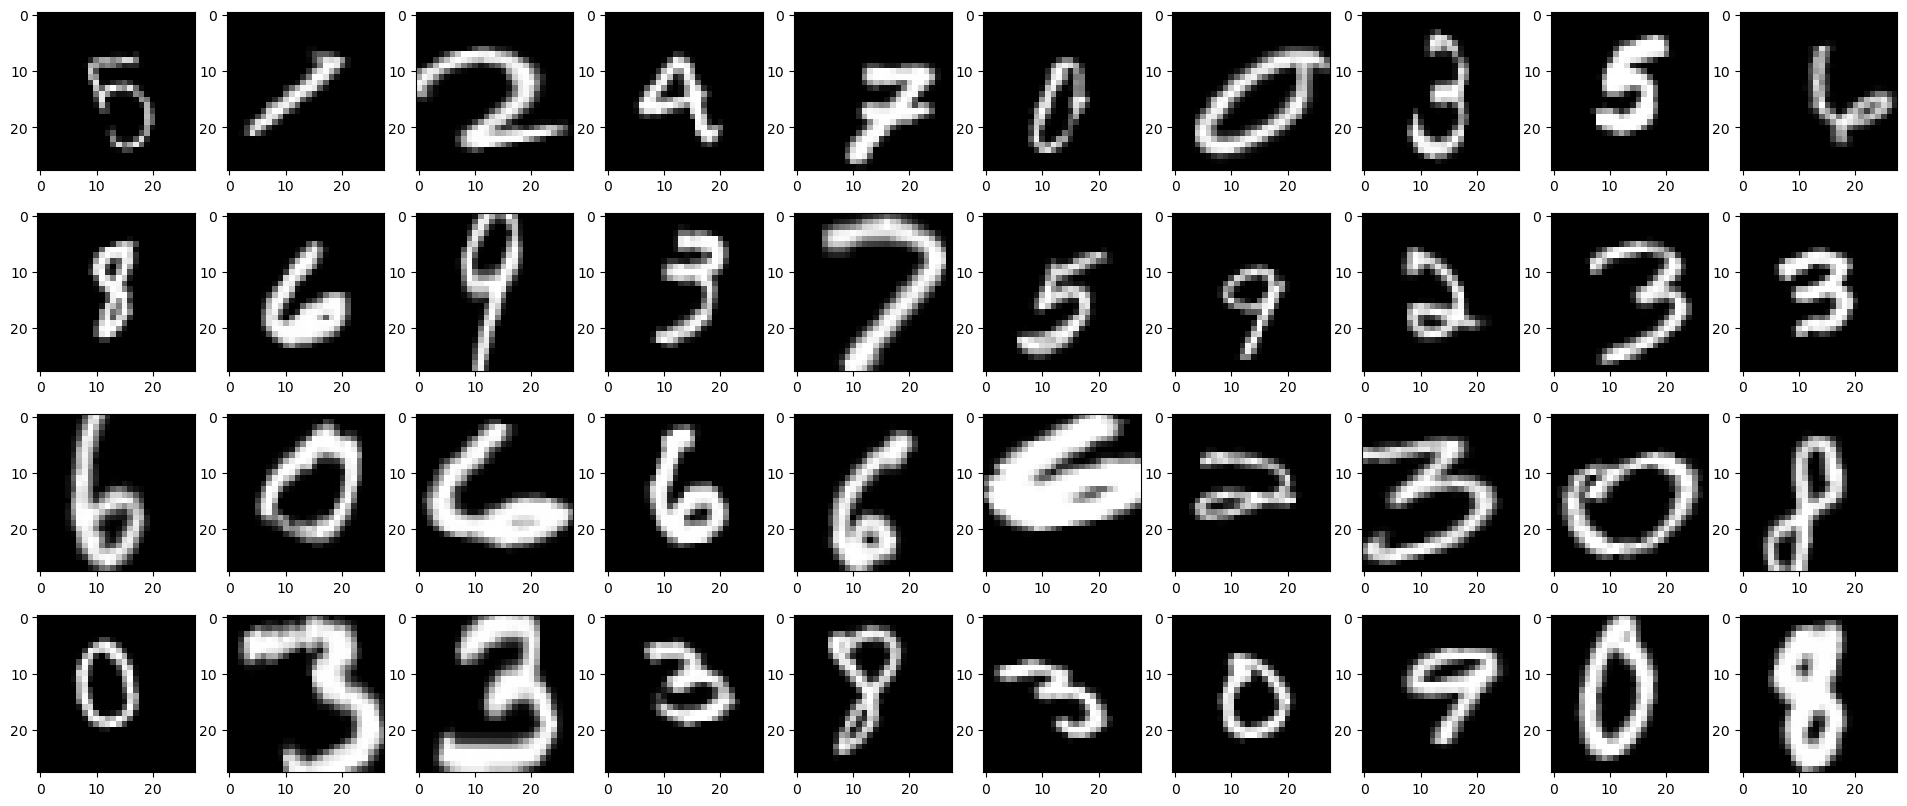

In [210]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.4,
    shear_range=0.2,
    fill_mode='nearest')

#Plots our figures
pic = datagen.flow(x_train, batch_size=1024)
plt.figure(figsize=(24,10))
for i in range(1,41):
  plt.subplot(4, 10, i)
  batch = pic.next()
  image_ = batch[0].astype('float32')
  plt.imshow(image_, cmap='gray')
plt.show()

# Define the CNN model

In [211]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_47 (Bat  (None, 12, 12, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_30 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 5, 5, 128)      

In [212]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# K-fold cross-validation

In [214]:
# Train and evaluate the model with k-fold cross-validation
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, f1_score, recall_score


historys = []
accuracies = []
losses = []
precisions = []
f1_scores = []
recalls = []

batch_size = 1024
epochs = 20
n_splits = 10

kfold = KFold(n_splits=n_splits, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5)])
    
    historys.append(history)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Accuracy:', accuracy)
    print('Loss:', loss)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    accuracies.append(accuracy)
    losses.append(loss)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

print('Average accuracy:', np.mean(accuracies))
print('Average loss:', np.mean(losses))
print('Average precision:', np.mean(precisions))
print('Average recall:', np.mean(recalls))
print('Average F1-score:', np.mean(f1_scores))

Fold: 1
Epoch 1/20


2023-02-20 15:22:31.561955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.7064

2023-02-20 15:22:36.574713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 9s 174ms/step - loss: 0.9032 - accuracy: 0.7064 - val_loss: 2.2103 - val_accuracy: 0.1971
Epoch 2/20
47/47 [==============================] - 8s 163ms/step - loss: 0.3071 - accuracy: 0.9057 - val_loss: 2.2405 - val_accuracy: 0.1342
Epoch 3/20
47/47 [==============================] - 8s 161ms/step - loss: 0.2246 - accuracy: 0.9318 - val_loss: 2.1859 - val_accuracy: 0.2256
Epoch 4/20
47/47 [==============================] - 8s 164ms/step - loss: 0.1876 - accuracy: 0.9437 - val_loss: 2.2462 - val_accuracy: 0.1302
Epoch 5/20
47/47 [==============================] - 8s 162ms/step - loss: 0.1669 - accuracy: 0.9505 - val_loss: 1.9653 - val_accuracy: 0.3582
Epoch 6/20
47/47 [==============================] - 8s 159ms/step - loss: 0.1458 - accuracy: 0.9565 - val_loss: 1.9057 - val_accuracy: 0.4611
Epoch 7/20
47/47 [==============================] - 8s 160ms/step - loss: 0.1318 - accuracy: 0.9609 - val_loss: 1.8434 - val_accuracy: 0.4177
Epoch 8/20
47/47 

2023-02-20 15:25:04.169736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 27/313 [=>............................] - ETA: 1s

2023-02-20 15:25:07.417488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 4ms/step
Accuracy: 0.9901000261306763
Loss: 0.029343878850340843
Precision: 0.9901031696091829
Recall: 0.9903699353724447
F1-score: 0.9902003797231304
Fold: 2
Epoch 1/20
47/47 [==============================] - 8s 160ms/step - loss: 0.0765 - accuracy: 0.9773 - val_loss: 0.0426 - val_accuracy: 0.9863
Epoch 2/20
47/47 [==============================] - 8s 159ms/step - loss: 0.0760 - accuracy: 0.9769 - val_loss: 0.0377 - val_accuracy: 0.9888
Epoch 3/20
47/47 [==============================] - 8s 159ms/step - loss: 0.0724 - accuracy: 0.9787 - val_loss: 0.0883 - val_accuracy: 0.9732
Epoch 4/20
47/47 [==============================] - 7s 158ms/step - loss: 0.0744 - accuracy: 0.9785 - val_loss: 0.0391 - val_accuracy: 0.9885
Epoch 5/20
47/47 [==============================] - 8s 161ms/step - loss: 0.0675 - accuracy: 0.9792 - val_loss: 0.0758 - val_accuracy: 0.9751
Epoch 6/20
47/47 [==============================] - 8s 160ms/step - loss: 0.0689 - ac

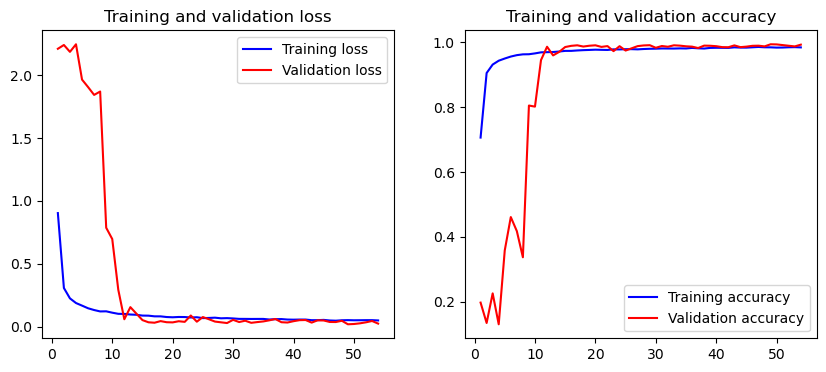

In [217]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [216]:
model.save("network_for_mnist.h5")